# Autoencoder convolucional (VAE) - test

In [1]:
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from keras.models import Sequential, load_model, Model
from keras import layers
from keras.layers import Activation, concatenate, merge, Dropout, Reshape, Flatten, Dense, Input, Lambda, Conv2D, UpSampling2D, MaxPooling2D, GlobalAveragePooling2D, GlobalAveragePooling3D, Conv2DTranspose
from keras import backend as K
from keras.callbacks import EarlyStopping, ModelCheckpoint,ReduceLROnPlateau, LearningRateScheduler
from keras.applications import VGG16, VGG19, InceptionV3, Xception, resnet50
from keras import losses

from scipy.stats import norm
import sklearn_extensions as ske
from sklearn_extensions.fuzzy_kmeans import KMedians, FuzzyKMeans, KMeans

import os
import glob
from keras import metrics
from PIL import Image, ImageFilter
import tensorflow as tf
import cv2

import sys
from tqdm import tqdm_notebook
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from skimage import exposure
from skimage import io
import imageio
from skimage.color import rgb2gray
from skimage import exposure

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import warnings

from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, cohen_kappa_score, accuracy_score
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc

%matplotlib inline

C:\Users\roberto\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
train_data_dir = 'D:/MBIT-2017-18-Master-Deep-Learning/Reto TGS Kaggle - imágenes con sal/test/images'

In [3]:
train_ids = next(os.walk(train_data_dir))[2]
train_ids[0:5]

['0005bb9630.png',
 '000a68e46c.png',
 '000c8dfb2a.png',
 '000d0a5f6c.png',
 '001ef8fc87.png']

In [4]:
id_train = []
for i in range(len(train_ids)):
    id_train = id_train + [(train_ids[i].split(".")[0])]
    
id_train[0:5]

['0005bb9630', '000a68e46c', '000c8dfb2a', '000d0a5f6c', '001ef8fc87']

In [5]:
data_train = pd.DataFrame(id_train,columns=["id"])
data_train["nombre"] = train_ids

In [6]:
data_train.head()

,id,nombre
0,0005bb9630,0005bb9630.png
1,000a68e46c,000a68e46c.png
2,000c8dfb2a,000c8dfb2a.png
3,000d0a5f6c,000d0a5f6c.png
4,001ef8fc87,001ef8fc87.png


In [7]:
train_ids = next(os.walk("D:/MBIT-2017-18-Master-Deep-Learning/Reto TGS Kaggle - imágenes con sal/test/images/"))[2]

In [8]:
print(len(train_ids))


18000


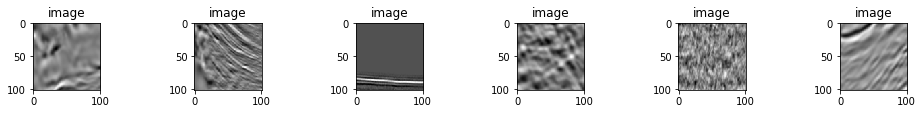

In [9]:
ids= train_ids[130:136]
plt.figure(figsize=(20,10))
for j, img_name in enumerate(ids):
    q = j+1
    img = load_img('D:/MBIT-2017-18-Master-Deep-Learning/Reto TGS Kaggle - imágenes con sal/test/images/' + img_name)
    
    plt.subplot(1,2*(1+len(ids)),q*2-1)
    plt.title('image')
    plt.imshow(img,)
    
plt.show()

In [10]:
im_width = 128
im_height = 128
im_chan = 1

In [11]:
# Get and resize train images and masks
X_train = np.zeros((len(train_ids), im_height, im_width, im_chan), dtype=np.uint8)
Y_train = np.zeros((len(train_ids), im_height, im_width, 1), dtype=np.bool)
print('Getting and resizing train images and masks ... ')
sys.stdout.flush()
for n, id_ in tqdm_notebook(enumerate(train_ids), total=len(train_ids)):
    
    img = load_img('D:/MBIT-2017-18-Master-Deep-Learning/Reto TGS Kaggle - imágenes con sal/test/images/' + id_) 
    x = img_to_array(img)[:,:,1]
    x = resize(x, (im_height, im_width, im_chan), mode='constant', preserve_range=True)
    X_train[n] = x
    
print('Done!')

Getting and resizing train images and masks ... 


HBox(children=(IntProgress(value=0, max=18000), HTML(value='')))


Done!


In [12]:
X_train = X_train / 255

In [13]:
x_train, x_val, y_train, y_val = train_test_split(X_train, Y_train, test_size=0.25, random_state=42)

In [14]:
# input image dimensions
img_rows, img_cols, img_chns = 128, 128, 1
# number of convolutional filters to use
filters = 64
# convolution kernel size
num_conv = 3

if K.image_data_format() == 'channels_first':
    original_img_size = (img_chns, img_rows, img_cols)
else:
    original_img_size = (img_rows, img_cols, img_chns)
latent_dim = 2
intermediate_dim = 128
epsilon_std = 1.0

batch_size = 64
epochs = 75

x = Input(shape=original_img_size)
conv_1 = Conv2D(img_chns,
                kernel_size=(2, 2),
                padding='same', activation='relu')(x)
conv_2 = Conv2D(filters,
                kernel_size=(2, 2),
                padding='same', activation='relu',
                strides=(2, 2))(conv_1)
conv_3 = Conv2D(filters,
                kernel_size=num_conv,
                padding='same', activation='relu',
                strides=1)(conv_2)
conv_4 = Conv2D(filters,
                kernel_size=num_conv,
                padding='same', activation='relu',
                strides=1)(conv_3)
flat = Flatten()(conv_4)
hidden = Dense(intermediate_dim, activation='relu')(flat)

z_mean = Dense(latent_dim)(hidden)
z_log_var = Dense(latent_dim)(hidden)


def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim),
                              mean=0., stddev=epsilon_std)
    return z_mean + K.exp(z_log_var) * epsilon

# note that "output_shape" isn't necessary with the TensorFlow backend
# so you could write `Lambda(sampling)([z_mean, z_log_var])`
z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])

# we instantiate these layers separately so as to reuse them later
decoder_hid = Dense(intermediate_dim, activation='relu')
decoder_upsample = Dense(filters * 64 * 64, activation='relu')

if K.image_data_format() == 'channels_first':
    output_shape = (batch_size, filters, 64, 64)
else:
    output_shape = (batch_size, 64, 64, filters)

decoder_reshape = Reshape(output_shape[1:])
decoder_deconv_1 = Conv2DTranspose(filters,
                                   kernel_size=num_conv,
                                   padding='same',
                                   strides=1,
                                   activation='relu')
decoder_deconv_2 = Conv2DTranspose(filters,
                                   kernel_size=num_conv,
                                   padding='same',
                                   strides=1,
                                   activation='relu')
if K.image_data_format() == 'channels_first':
    output_shape = (batch_size, filters, 129, 129)
else:
    output_shape = (batch_size, 129, 129, filters)
decoder_deconv_3_upsamp = Conv2DTranspose(filters,
                                          kernel_size=(3, 3),
                                          strides=(2, 2),
                                          padding='valid',
                                          activation='relu')
decoder_mean_squash = Conv2D(img_chns,
                             kernel_size=2,
                             padding='valid',
                             activation='sigmoid')

hid_decoded = decoder_hid(z)
up_decoded = decoder_upsample(hid_decoded)
reshape_decoded = decoder_reshape(up_decoded)
deconv_1_decoded = decoder_deconv_1(reshape_decoded)
deconv_2_decoded = decoder_deconv_2(deconv_1_decoded)
x_decoded_relu = decoder_deconv_3_upsamp(deconv_2_decoded)
x_decoded_mean_squash = decoder_mean_squash(x_decoded_relu)

# instantiate VAE model
vae = Model(x, x_decoded_mean_squash)

# define the loss function
xent_loss = img_rows * img_cols * metrics.binary_crossentropy(
    K.flatten(x),
    K.flatten(x_decoded_mean_squash))
kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
vae_loss = K.mean(xent_loss + kl_loss)
vae.add_loss(vae_loss)

vae.compile(optimizer='rmsprop', metrics=['accuracy'])


C:\Users\roberto\Anaconda3\lib\site-packages\ipykernel_launcher.py:105: UserWarning: Output "conv2d_5" missing from loss dictionary. We assume this was done on purpose, and we will not be expecting any data to be passed to "conv2d_5" during training.


In [15]:
vae.load_weights('weights_VAE_TGS_v1.h5')

In [16]:
encoder = Model(x, z_mean)

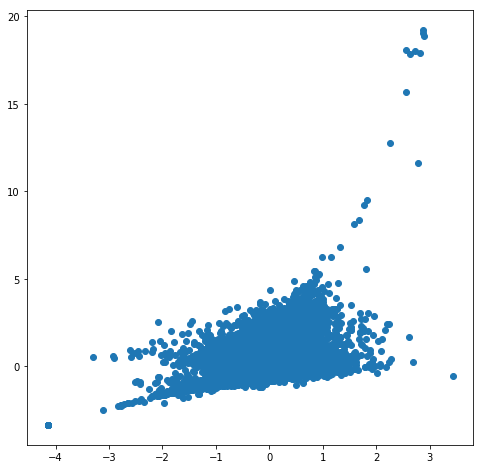

In [17]:
x_latente = encoder.predict(X_train, batch_size=batch_size)
plt.figure(figsize=(8, 8))
plt.scatter(x_latente[:, 0], x_latente[:, 1])
plt.show()

In [18]:
data_train["x_lat"] = x_latente[:, 0]
data_train["y_lat"] = x_latente[:, 1]

In [19]:
data_latente = data_train.iloc[:,2:]

Text(0.5,1,'Elbow curve')

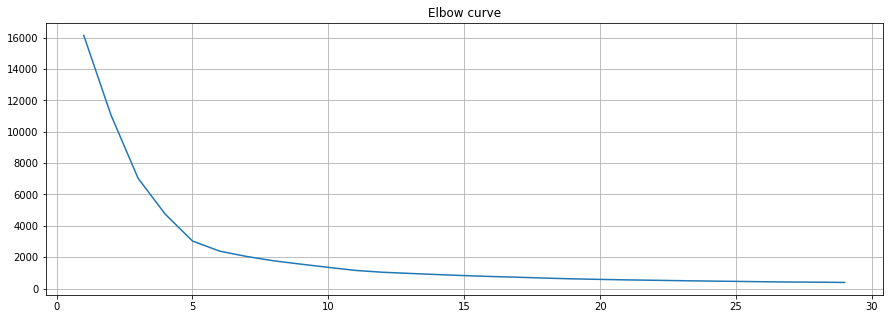

In [118]:
from sklearn.cluster import KMeans

distorsions = []
for k in range(1, 30):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(data_latente)
    distorsions.append(kmeans.inertia_)

fig = plt.figure(figsize=(15, 5))
plt.plot(range(1, 30), distorsions)
plt.grid(True)
plt.title('Elbow curve')

In [20]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=6, random_state=0).fit(data_latente)
num_cluster = (kmeans.labels_.reshape(data_latente.shape[0],1)) + 1
print(num_cluster)

[[1]
 [3]
 [4]
 ...
 [5]
 [1]
 [4]]


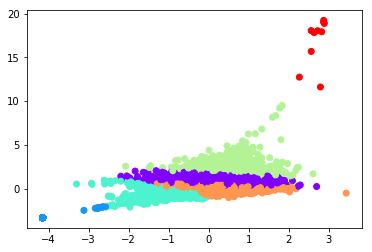

In [21]:
plt.scatter(data_latente.iloc[:,0],data_latente.iloc[:,1], c=kmeans.labels_, cmap='rainbow') 

In [22]:
data_train["cluster"] = num_cluster

In [23]:
data_train.head()

,id,nombre,x_lat,y_lat,cluster
0,0005bb9630,0005bb9630.png,-0.126332,0.651734,1
1,000a68e46c,000a68e46c.png,-1.129966,-0.742243,3
2,000c8dfb2a,000c8dfb2a.png,0.113398,2.815214,4
3,000d0a5f6c,000d0a5f6c.png,0.231385,0.276118,5
4,001ef8fc87,001ef8fc87.png,0.087010,0.298943,5


In [24]:
unique_elements, counts_elements = np.unique(num_cluster, return_counts=True)
print("Frequency of cluster:")
print(np.asarray((unique_elements, counts_elements))) 

Frequency of cluster:
[[   1    2    3    4    5    6]
 [3867  442 3725 1259 8697   10]]


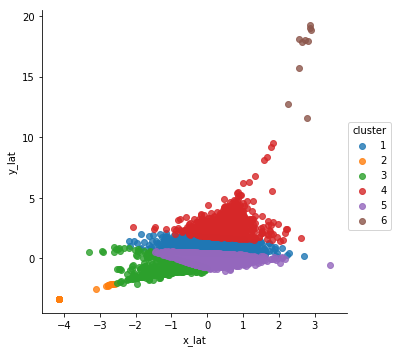

In [25]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

facet = sns.lmplot(data=data_train, x='x_lat', y='y_lat', hue='cluster', fit_reg=False, legend=True, legend_out=True)

In [26]:
c1 = data_train.loc[(data_train['cluster'] == 1)]
c2 = data_train.loc[(data_train['cluster'] == 2)]
c3 = data_train.loc[(data_train['cluster'] == 3)]
c4 = data_train.loc[(data_train['cluster'] == 4)]
c5 = data_train.loc[(data_train['cluster'] == 5)]
c6 = data_train.loc[(data_train['cluster'] == 6)]

c1.to_csv("D:/MBIT-2017-18-Master-Deep-Learning/Reto TGS Kaggle - imágenes con sal/ETL/TGS_test_c4.csv",decimal=',',sep=';')
c2.to_csv("D:/MBIT-2017-18-Master-Deep-Learning/Reto TGS Kaggle - imágenes con sal/ETL/TGS_test_c3.csv",decimal=',',sep=';')
c3.to_csv("D:/MBIT-2017-18-Master-Deep-Learning/Reto TGS Kaggle - imágenes con sal/ETL/TGS_test_c5.csv",decimal=',',sep=';')
c4.to_csv("D:/MBIT-2017-18-Master-Deep-Learning/Reto TGS Kaggle - imágenes con sal/ETL/TGS_test_c2.csv",decimal=',',sep=';')
c5.to_csv("D:/MBIT-2017-18-Master-Deep-Learning/Reto TGS Kaggle - imágenes con sal/ETL/TGS_test_c1.csv",decimal=',',sep=';')
c6.to_csv("D:/MBIT-2017-18-Master-Deep-Learning/Reto TGS Kaggle - imágenes con sal/ETL/TGS_test_c6.csv",decimal=',',sep=';')

data_train.to_csv("D:/MBIT-2017-18-Master-Deep-Learning/Reto TGS Kaggle - imágenes con sal/ETL/TGS_test_cluster.csv",decimal=',',sep=';')